### Generate the Illustrative Plot for SparTSM using Fourier Model for $\partial_t \theta(t)$. 

See ```loggle/README.md``` for procedures to generate $\theta(t)$ using Loggle.

In [1]:
# %%

import torch 
import matplotlib.pyplot as plt

def g(t):
    return -(t-1)*t

def dg(t):
    return -2*t+1

def f(x):
    n, d, nt = x.shape
    pairwise_features = torch.zeros((n, d * (d + 1) // 2, nt))
    
    idx = 0
    for i in range(d):
        for j in range(i, d):
            pairwise_features[:, idx, :] = x[:, i, :] * x[:, j, :]
            idx += 1
            
    return pairwise_features


def phi(fXqt, t, sigma = .1): # NW estimator
    Kt = torch.exp(-(t[:, None] - t[:, None].T)**2/sigma**2/2)
    Eqtfx = fXqt[0, :, :] @ Kt / torch.sum(Kt, 1)
    return fXqt - Eqtfx
    
    # return fXqt - torch.mean(fXqt, 0)

def fourierfea(b, t):
    freq = torch.arange(b, dtype=torch.float32)
    fourier_features = torch.cat([freq * torch.cos(freq * t), -freq *torch.sin(freq * t)], dim=-1)

    return fourier_features

def dfourierfea(b, t):
    freq = torch.arange(b, dtype=torch.float32)
    fourier_features = torch.cat([-freq**2 *torch.sin(freq * t), -freq**2 *torch.cos(freq * t)], dim=-1)

    return fourier_features

def fea(t, b, d):
    F = torch.zeros(t.shape[0], 2*b, d)
    for i in range(d):
        # fouier features
        # F[:, :, i] = torch.ones_like(t)
        F[:, :, i] = fourierfea(b, t)
    
    return F

def dfea(t, b, d):
    F = torch.zeros(t.shape[0], 2*b, d)
    for i in range(d):
        # fouier features
        # F[:, :, i] = torch.zeros_like(t)
        F[:, :, i] = dfourierfea(b, t)
    
    return F

def obj(alpha, phiXqt, fXqt, F, dF):
    
    n = phiXqt.shape[0]
    
    dthetat = torch.sum(alpha * F, 1).transpose(1, 0)
    d2thetat = torch.sum(alpha * dF, 1).transpose(1, 0)
    
    obj1 = torch.mean((torch.sum(phiXqt * dthetat, 1)**2) @ g(t) , 0)
    obj2 = torch.ones(1,n) @ torch.sum(fXqt * dthetat, 1) / n @ dg(t)
    obj3 = torch.ones(1,n) @ torch.sum(fXqt * d2thetat, 1) / n @ g(t)
    
    return obj1 + 2*obj2 + 2*obj3

In [2]:
# %% train TSM objective

def train(X, t, lmbd = .001, num_epochs=100, learning_rate=0.0001):
    phiXqt = phi(f(X), t)
    fXqt = f(X)
    
    n = phiXqt.shape[0]
    d = phiXqt.shape[1]
    
    k = 5 # number of fourier features
    F = fea(t[:, None], k, d)
    dF = dfea(t[:, None], k, d)

    alpha = torch.zeros(2*k, f(X).shape[1], requires_grad=True) 
    optimizer = torch.optim.Adam([alpha], lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad() 

        # group lasso penalty on each column
        pen = 0
        for i in range(d):
            pen += torch.norm(alpha[:, i], 2)

        loss = obj(alpha, phiXqt, fXqt, F, dF)  + lmbd * pen
        loss.backward()  

        optimizer.step()  

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return alpha

generating samples for each time point ..., may take a while...done.


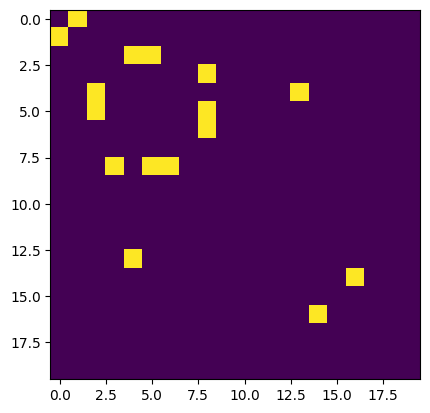

In [3]:
# %% generating samples

torch.manual_seed(2)
n = 1
nt = 5000
d = 20

G = torch.rand(d, d) + torch.eye(d) < .023
G = G + G.t()
plt.imshow(G)

Xqt = torch.zeros(n, d, nt)
t = torch.rand(nt)
base = torch.randn(d, 2*d)
base = base @ base.T/2/d

print("generating samples for each time point ..., may take a while...", end="")
for i in range(nt):
    nz = torch.zeros(1, d)
    # nz[0, 2] = 1
    # nz[0, 3] = 1
    mu = torch.zeros(1, d) + t[i]*nz
    Theta = torch.eye(d)
    Theta = Theta + base
    Theta.fill_diagonal_(2.0)
    Theta[G == 1] = .5*torch.sin(t[i]*10)
                
    Cov = torch.inverse(Theta)
    Xqt[:, :, i] = torch.distributions.MultivariateNormal(mu, Cov).sample((n,)).squeeze()
    
print("done.")

In [4]:
# %% training TSM
alpha_hat = train(Xqt, t, lmbd= 1000, learning_rate=0.001, num_epochs=1000)

Epoch 0, Loss: 0.0
Epoch 10, Loss: -35.268463134765625
Epoch 20, Loss: -209.1539306640625
Epoch 30, Loss: -338.45880126953125
Epoch 40, Loss: -437.922119140625
Epoch 50, Loss: -518.0941162109375
Epoch 60, Loss: -585.0543823242188
Epoch 70, Loss: -642.2354125976562
Epoch 80, Loss: -690.055908203125
Epoch 90, Loss: -732.5640258789062
Epoch 100, Loss: -766.014404296875
Epoch 110, Loss: -795.9559326171875
Epoch 120, Loss: -821.418212890625
Epoch 130, Loss: -844.7064208984375
Epoch 140, Loss: -862.64794921875
Epoch 150, Loss: -879.4505615234375
Epoch 160, Loss: -894.01806640625
Epoch 170, Loss: -907.2828369140625
Epoch 180, Loss: -919.0782470703125
Epoch 190, Loss: -929.6572265625
Epoch 200, Loss: -937.44091796875
Epoch 210, Loss: -945.3902587890625
Epoch 220, Loss: -951.1041259765625
Epoch 230, Loss: -956.869140625
Epoch 240, Loss: -963.122314453125
Epoch 250, Loss: -967.621826171875
Epoch 260, Loss: -971.8394775390625
Epoch 270, Loss: -976.035400390625
Epoch 280, Loss: -979.2322998046875


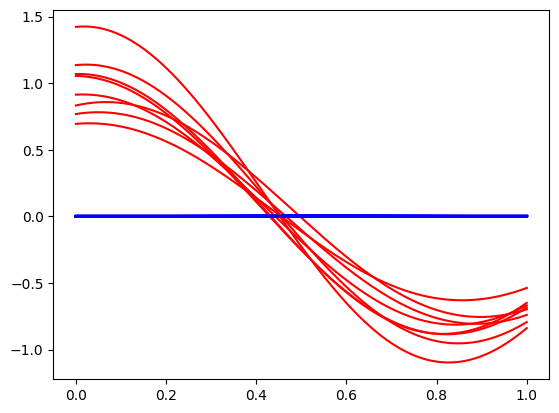

In [5]:
# %%

t = torch.linspace(0, 1, 1000)
F = fea(t[:, None], 5, f(Xqt).shape[1])
dthetat = torch.sum(alpha_hat * F, 1).transpose(1, 0)


idx = 0
for i in range(d):
    for j in range(i, d):
        if i != j:
            if G[i, j] == 1:
                plt.plot(t, dthetat[idx, :].detach().numpy(), c='r')
            else:
                plt.plot(t, dthetat[idx, :].detach().numpy(), c='b')
        idx += 1
